# Computer Vision Group Project 

### Topic - Image Denoising on Fashion MNIST dataset

```
Submitted by:
Aryaman Gautam (J001)
Aayushmaan Jain (J022)
Pratyush Patro (J047)
Milindi Shah (J057)
```

In [ ]:
# Imports 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import KFold
plt.style.use('seaborn')

In [ ]:
# Checking for GPU Availability
print(f'Supports GPU -> {tf.test.is_built_with_gpu_support()}')
print(f'Supports CUDA -> {tf.test.is_built_with_cuda()}')
print(f"Number of GPU -> {len(tf.config.list_physical_devices('GPU'))}")

Supports GPU -> True
Supports CUDA -> True
Number of GPU -> 1


In [ ]:
# Loading the data
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# Seeing the dimensions of our data 
print(f'Images for the train set -> {X_train.shape}')
print(f'Labels for the train set -> {y_train.shape}')
print(f'Images for the test set -> {X_test.shape}')
print(f'Labels for the test set -> {y_test.shape}')

Images for the train set -> (60000, 28, 28)
Labels for the train set -> (60000,)
Images for the test set -> (10000, 28, 28)
Labels for the test set -> (10000,)


In [ ]:
# Initializing the labels as the labels in the tensorflow dataset are encoded, hence we need to decode them
# in order to make them readable for humans 
labels = {
    0:'T-shirt/Top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle Boot'
}
y_train = pd.Series([labels[val] for val in y_train]) # decoding the labels for train set
y_test = pd.Series(labels[val] for val in y_test) # decoding the labels for test set

In [ ]:
# Checking proportion of Images in train set
print(y_train.value_counts(normalize=True).apply(lambda x: f'{x:.3%}'))

Ankle Boot     10.000%
T-shirt/Top    10.000%
Dress          10.000%
Pullover       10.000%
Sneaker        10.000%
Sandal         10.000%
Trouser        10.000%
Shirt          10.000%
Coat           10.000%
Bag            10.000%
dtype: object


In [ ]:
# Checking proportion of Images in test set
print(y_test.value_counts(normalize=True).apply(lambda x: f'{x:.3%}'))

Ankle Boot     10.000%
Pullover       10.000%
Trouser        10.000%
Shirt          10.000%
Coat           10.000%
Sandal         10.000%
Sneaker        10.000%
Dress          10.000%
Bag            10.000%
T-shirt/Top    10.000%
dtype: object


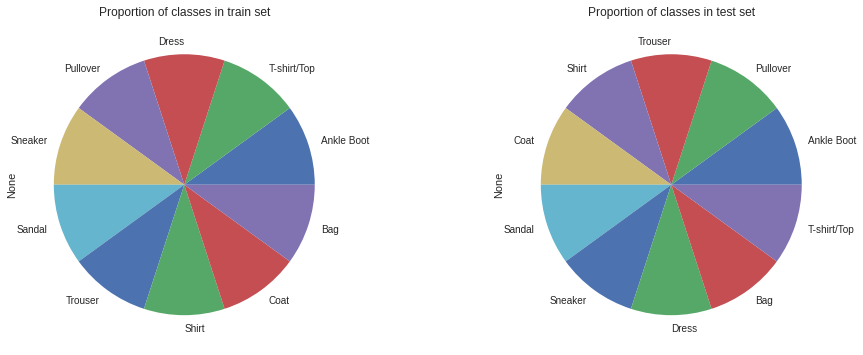

In [ ]:
# Plotting a pie chart of the proportions of each category of fashion apparel in train and test set
fig, ax = plt.subplots(figsize=(16,6),nrows=1, ncols=2)
y_train.value_counts().plot(kind='pie',ax=ax[0], title='Proportion of classes in train set')
y_test.value_counts().plot(kind='pie',ax=ax[1], title='Proportion of classes in test set')
plt.show()

In [ ]:
def seeExamples(data:np.array, labels:pd.Series, nrows=4,ncols=4, random_state=42)->None:
    """Helps us to visualize random exampes from the dataset

    Args:
        data (np.array): The array of images from which you would like to visualize
        labels (pd.Series): The labels of the images to be visualized
        nrows (int, optional): The number of rows you would like to have in your plot. Defaults to 4.
        ncols (int, optional): The number of columns you would like to have in your plot. Defaults to 4.
        random_state (int, optional): The seed to be set while generating random numbers. Defaults to 42.
    """    
    # Deciding the size of the figure in accordance of the number of rows and columns to plot the data in
    FIGSIZE=(nrows, ncols)
    # Calculating the number of examples in the dataset we have to plot 
    numExamples = len(data)
    # Setting the seed for generating random numbers 
    np.random.seed(random_state)
    # Initializing the random indices to chose random examples for plotting
    indices = np.random.randint(low=0, high=numExamples, size=(nrows, ncols))
    # Making a figure with the desired number of rows and columns
    _, ax = plt.subplots(figsize=FIGSIZE, nrows=nrows, ncols=ncols)
    # Looping through the rows 
    for i in range(nrows):
        # Looping through the columns
        for j in range(ncols):
            # Extracting the image at that index
            image = data[indices[i,j]]
            # Extracting the label for the image at that index
            label = labels[indices[i,j]]
            # Plotting the image and setting the title 
            ax[i,j].axis('off')
            ax[i,j].imshow(image, cmap='gray')
            ax[i,j].set_title(label)
    # Tight layout so that the images do not overlap
    plt.tight_layout()
    # Showing the plot 
    plt.show()

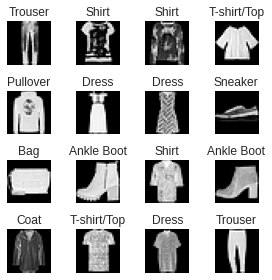

In [ ]:
# Seeing some examples from train set
seeExamples(X_train, y_train)

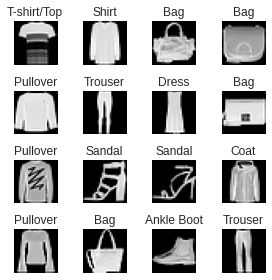

In [ ]:
# Seeing some examples from the test set
seeExamples(X_test, y_test)

In [ ]:
# Expanding the dimension to add the color channel (which is necessary to provide 3 dimensional inputs to the convolution layers)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
# Rescaling the pixels of the images in train and test set to be between 0 and 1 for faster convergence 
X_train = X_train / 255.0
X_test = X_test/255.0

In [ ]:
noise_factor = 0.2
# Adding white Gaussian Noise
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape) 
X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)

In [ ]:
def seeNoise(data:np.array,noisyData:tf.Tensor, labels:pd.Series, numExamples=10,random_state=42)->None:
    """Visualizes the images before and after adding the white noise

    Args:
        data (np.array): The images without noise
        noisyData (tf.Tensor): The images with noise
        labels (pd.Series): The labels for the images
        numExamples (int, optional): The number of examples to visualize. Defaults to 10.
        random_state (int, optional): The seed to be set while generating random numbers. Defaults to 42.
    """    
    # Calculating the number of examples in the dataset
    examples = len(data)
    # Setting the seed for generating random numbers 
    np.random.seed(random_state)
    # Generating the indices for selecting random examples
    indices = np.random.randint(low=0, high=examples, size=(numExamples,))
    # Initializing the figure in accordance with the number of examples
    FIGSIZE=(numExamples*2.5,5)
    # Creating a figure
    _,ax = plt.subplots(nrows=2, ncols=numExamples, figsize=FIGSIZE) 
    # Looping through the examples
    for i in range(numExamples):
        # Extracting the noisy image
        noisy = noisyData[indices[i]]
        # Extracting the original image 
        normal = data[indices[i]]
        # Extracting the label for that image 
        label = labels[indices[i]]
        # Showing the original image on the top row 
        ax[0,i].axis('off')
        ax[0,i].imshow(normal.reshape(28,28),cmap='gray')
        ax[0,i].set_title(f'Denoised Image of {label}')
        # Showing the noisy image on the bottom row 
        ax[1,i].axis('off')
        ax[1,i].imshow(noisy.numpy().reshape(28,28), cmap='gray')
        ax[1,i].set_title(f'Noisy Image of {label}')
    # Tight layout to avoid overlap
    plt.tight_layout()
    # Show the original and noisy images 
    plt.show()

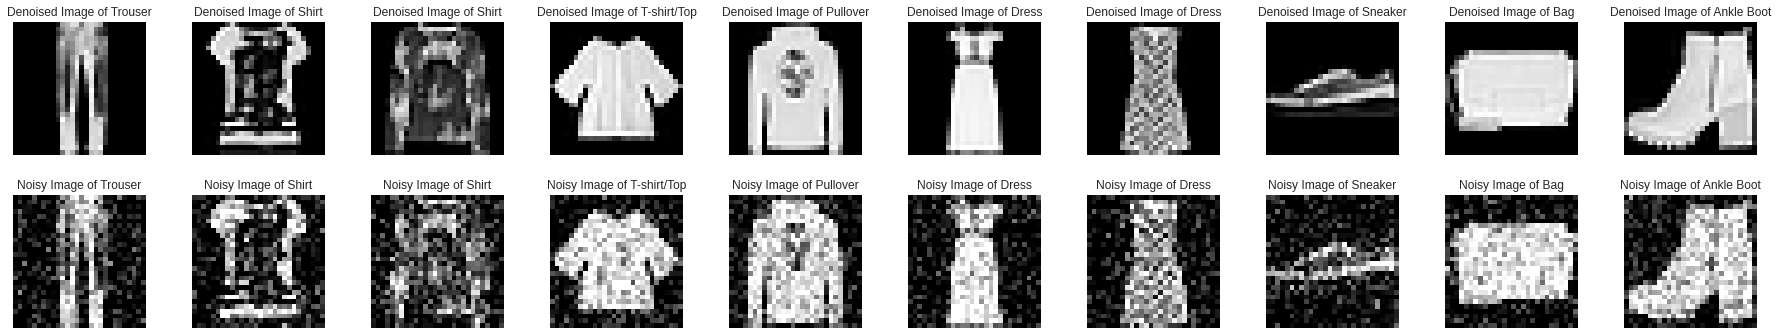

In [ ]:
# Seeing the noisy and original images of the train set
seeNoise(X_train, X_train_noisy, y_train)

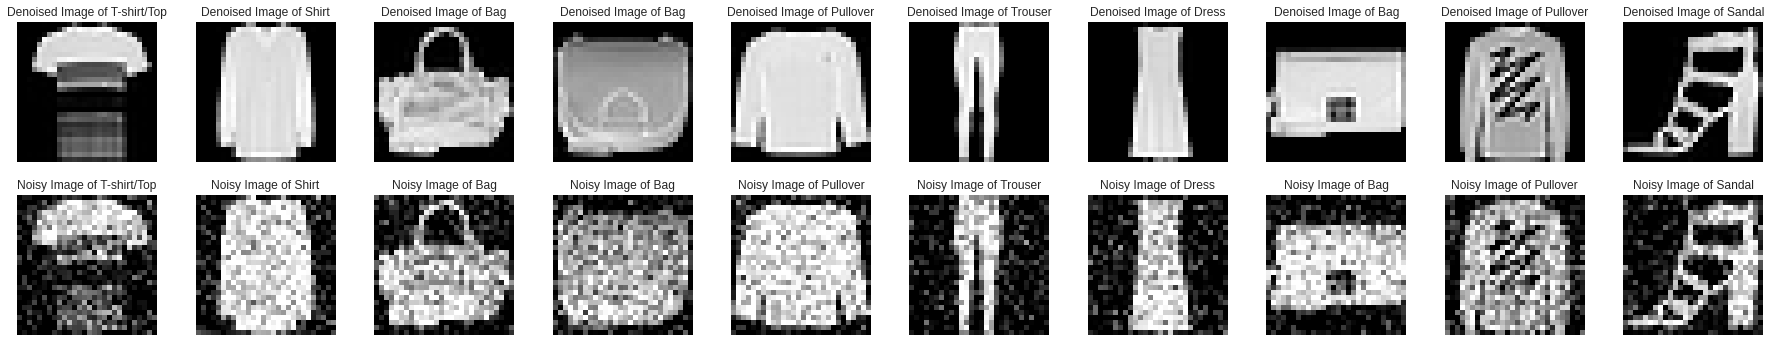

In [ ]:
# Seeing the noisy and original images of the test set
seeNoise(X_test, X_test_noisy, y_test)

In [ ]:
# Building the model 
class AutoEncoder(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    # Initializing the encoder architecture
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])
    # Initializing the decoder architecture
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    # Passing the inputs through the encoder
    encoded = self.encoder(x)
    # Passing the outputs of the encoder to the decoder
    decoded = self.decoder(encoded)
    return decoded
# Creating the autoencoder model
autoencoder = AutoEncoder()

In [ ]:
# Setting the loss function and optimizer of the autoencoder
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [ ]:
# Training the autoencoder for 10 epochs 
history = autoencoder.fit(X_train_noisy, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_test_noisy, X_test))

Epoch 1/10
1875/1875 [==============================] - 20s 6ms/step - loss: 0.0182 - val_loss: 0.0115
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - l

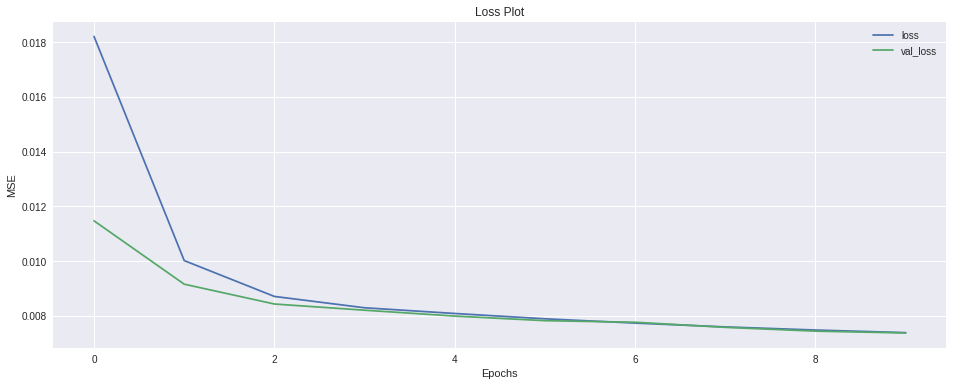

In [ ]:
# Plotting the losses 
history = pd.DataFrame(history.history)
fig, ax = plt.subplots(figsize=(16,6))
history.plot(ax=ax, title='Loss Plot',xlabel='Epochs',ylabel='MSE')
plt.show()

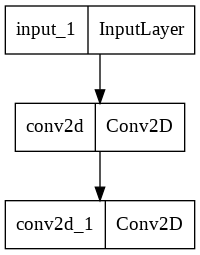

In [ ]:
# Visualize the encoder architecture
tf.keras.utils.plot_model(autoencoder.encoder)

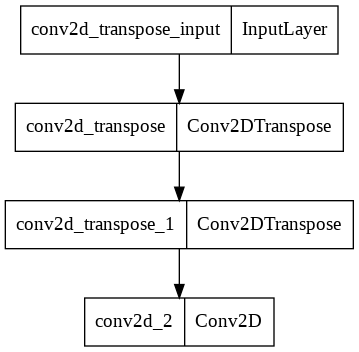

In [ ]:
# Visualize the decoder architecture
tf.keras.utils.plot_model(autoencoder.decoder)

In [ ]:
# Combining the dataset for K fold cross validation splits
X = tf.concat([X_train_noisy, X_test_noisy], axis=0)
y = np.concatenate([X_train,X_test], axis=0)

In [ ]:
folds = KFold(n_splits=5)
for fold, (train_ind, test_ind) in enumerate(folds.split(X,y)):
    print(f"{'='*50}Fold {fold+1}{'='*50}")
    noisy_images_train = X.numpy()[train_ind]
    target_images_train = y[train_ind]
    noisy_images_test = X.numpy()[test_ind]
    target_images_test = y[test_ind]

    model = AutoEncoder()
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(
        noisy_images_train, target_images_train,
        epochs=10,
        shuffle=True,
        validation_data=(noisy_images_test, target_images_test),
        verbose=0
    )
    test_loss = model.evaluate(noisy_images_test, target_images_test, verbose=0)
    print(f'MSE on test set for fold {fold+1} -> {test_loss}')
    print('\n')

==================================================Fold 1==================================================
MSE on test set for fold 1 -> 0.007525646593421698


==================================================Fold 2==================================================
MSE on test set for fold 2 -> 0.006989330518990755


==================================================Fold 3==================================================
MSE on test set for fold 3 -> 0.007077986374497414


==================================================Fold 4==================================================
MSE on test set for fold 4 -> 0.00678110821172595


==================================================Fold 5==================================================
MSE on test set for fold 5 -> 0.007046190090477467




In [ ]:
def seePredictions(data:np.array,noisyData:tf.Tensor, labels:pd.Series,model:tf.keras.models.Model, numExamples=10, random_state=42)->None:
    """See the performance of model on noisy images

    Args:
        data (np.array): The original data
        noisyData (tf.Tensor): The noisy data to denoise
        labels (pd.Series): The labels for the data
        model (tf.keras.models.Model): The model to be used for prediction
        numExamples (int, optional): The number of examples you would like to visualize. Defaults to 10.
        random_state (int, optional): The seed to be set while generating random numbers. Defaults to 42.
    """
    # Calculating the number of examples 
    examples = len(noisyData)    
    # Setting the seed for generating random numbers 
    np.random.seed(random_state)
    # Initializing the indices for selecting random examples 
    indices = np.random.randint(low=0, high=examples, size=(numExamples,))
    # Initializing the figsize according to the number of examples to display
    FIGSIZE=(numExamples*3,8)
    # Initializing the figure
    _, ax = plt.subplots(nrows=3, ncols=numExamples, figsize=FIGSIZE)
    # Looping through the examples 
    for i in range(numExamples):
        # Extracting the original image
        original = data[indices[i]]
        # Extracting the noisy image 
        image = noisyData[indices[i]]
        # Extracting the label for that image 
        label = labels[indices[i]]
        # Make predictions from the model 
        pred = model.predict(np.expand_dims(image,axis=0))
        # Show original image 
        ax[0,i].axis('off')
        ax[0,i].imshow(original.reshape(28,28), cmap='gray')
        ax[0,i].set_title(f'Original image of {label}')
        # Show the noisy image 
        ax[1,i].axis('off')
        ax[1,i].imshow(image.numpy().reshape(28,28),cmap='gray')
        ax[1,i].set_title(f'Noisy image of {label}')
        # Show the denoised image 
        ax[2,i].axis('off')
        ax[2,i].imshow(pred.reshape(28,28),cmap='gray')
        ax[2,i].set_title(f'Denoised image of {label}')
    # Tight layout to avoid overlap
    plt.tight_layout()
    # Show the original, noisy and denoised image 
    plt.show()

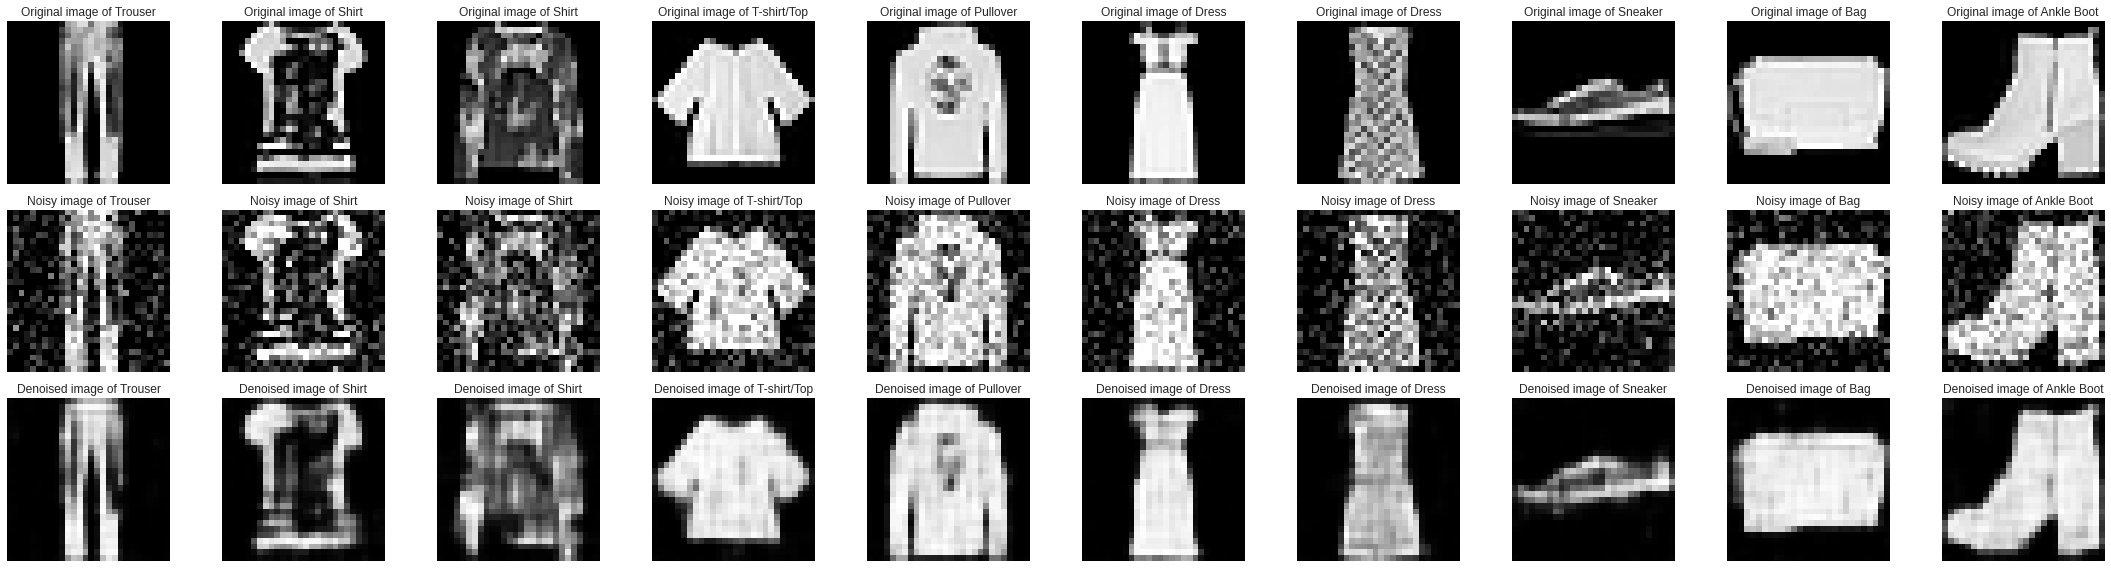

In [ ]:
# Seeing predictions on train data
seePredictions(data=X_train, noisyData=X_train_noisy,labels=y_train,model=autoencoder)

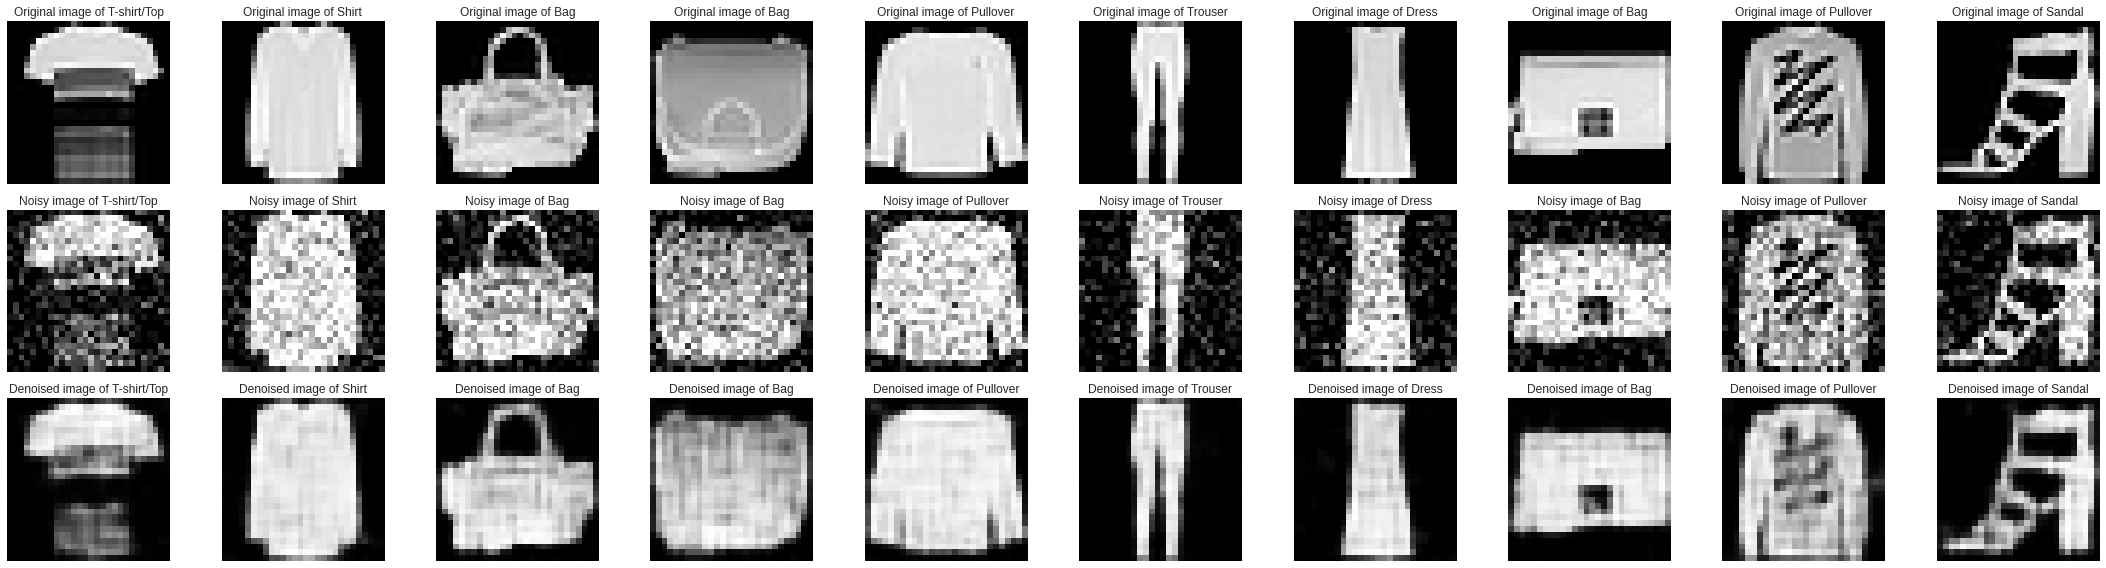

In [ ]:
# Seeing predictions on test data 
seePredictions(data=X_test, noisyData=X_test_noisy,labels=y_test,model=autoencoder)

In [ ]:
# Data Augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    rescale=1/255.0
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_set = train_generator.flow(X_train_noisy.numpy(), X_train)
test_set = test_generator.flow(X_test_noisy.numpy(), X_test)

In [ ]:
encoder = AutoEncoder()
encoder.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
history = encoder.fit(train_set, epochs=10, validation_data=test_set, shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 30s 15ms/step - loss: 0.1168 - val_loss: 0.1112
Epoch 2/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1118 - val_loss: 0.1112
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1118 - val_loss: 0.1111
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1117 - val_loss: 0.1112
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1117 - val_loss: 0.1111
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1118 - val_loss: 0.1112
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1117 - val_loss: 0.1117
Epoch 8/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1117 - val_loss: 0.1111
Epoch 9/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1117 - val_loss: 0.1112
Epoch 10/10
1875/1875 [==============================] - 27s 14m

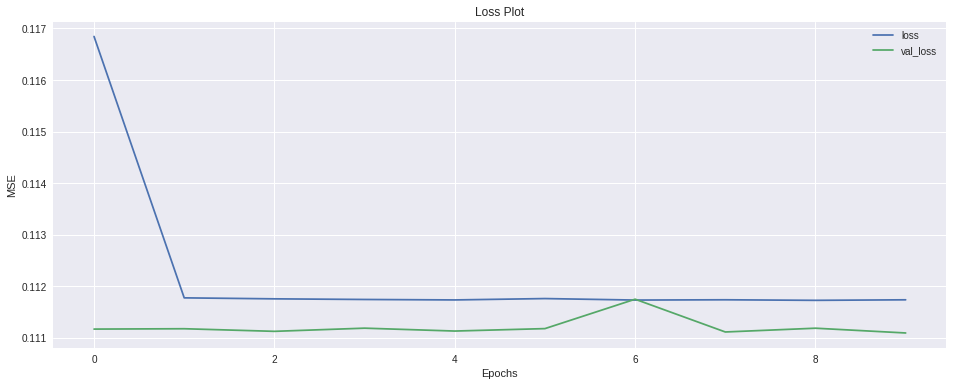

In [ ]:
# Plotting the losses 
history = pd.DataFrame(history.history)
fig, ax = plt.subplots(figsize=(16,6))
history.plot(ax=ax, title='Loss Plot',xlabel='Epochs',ylabel='MSE')
plt.show()